<a href="https://colab.research.google.com/github/FernandoCruvinel/Comptutaional-Intelegence-Society/blob/main/RedesNeuraisConvulucionais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title ## 1. Carregamento e pré-processamento dos dados

!mkdir -p clouds_data

!unzip -oq clouds.zip -d clouds_data  # -oq
!rm -rf clouds_data/__MACOSX # Retirar pasta macOS

import os
print("Contents of unzipped data:", os.listdir("clouds_data/clouds"))

Contents of unzipped data: ['clouds_test', 'clouds_train', '.DS_Store']


In [2]:

# @markdown Vamos definir transformações (data augmentation) para o conjunto de treino e outro conjunto de transformações para validação. Usaremos operações comuns como RandomResizedCrop, RandomHorizontalFlip e normalização (com médias e desvios padrão do ImageNet). Em seguida, criaremos datasets e dataloaders.
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


train_dir = "clouds_data/clouds/clouds_train"
test_dir = "clouds_data/clouds/clouds_test"


mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]


train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(test_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=2)


class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Number of classes: {num_classes}, Classes: {class_names}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Number of classes: 7, Classes: ['cirriform clouds', 'clear sky', 'cumulonimbus clouds', 'cumulus clouds', 'high cumuliform clouds', 'stratiform clouds', 'stratocumulus clouds']
Using device: cpu


Agora, vamos definir a arquitetura da CNN. Implementaremos uma classe PyTorch com várias camadas convolucionais intercaladas com Batch Normalization e ReLU, seguidas por camadas de pooling e dropout. No final, temos camadas lineares (FC) que mapeiam para o número de classes. Comentários detalhados explicam cada parte.

In [3]:
# @title ## 3. CNN Model Definition

import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(16)
        # Block 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(32)
        # Block 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)

        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):

        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(-1, 64 * 28 * 28)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


net = CNN(num_classes=num_classes).to(device)
print(net)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=7, bias=True)
)


A classe CNN acima define nossa rede convolucional do zero. Cada bloco convolucional consiste em Convolutional → BatchNorm → ReLU → MaxPool, que é um padrão comum para CNNs de classificação. As camadas BatchNorm2d normalizam as ativações de cada batch , melhorando a estabilidade do treinamento. O dropout (nn.Dropout) é usado após a primeira camada totalmente conectada para evitar overfitting (ele zera aleatoriamente neurônios com probabilidade 25%) . A saída final é uma camada linear com num_classes neurônios, cada um representando a pontuação (logit) para uma classe de nuvem.

Epoch 1/10 | Train Loss: 17.2673 Acc: 20.04% | Val Loss: 2.5683 Acc: 12.35%
Epoch 2/10 | Train Loss: 2.6921 Acc: 23.00% | Val Loss: 1.8902 Acc: 16.46%
Epoch 3/10 | Train Loss: 1.8110 Acc: 24.05% | Val Loss: 1.6662 Acc: 27.98%
Epoch 4/10 | Train Loss: 1.7235 Acc: 31.22% | Val Loss: 1.4822 Acc: 36.21%
Epoch 5/10 | Train Loss: 1.7067 Acc: 28.90% | Val Loss: 1.4017 Acc: 54.94%
Epoch 6/10 | Train Loss: 1.5985 Acc: 36.71% | Val Loss: 1.3023 Acc: 38.68%
Epoch 7/10 | Train Loss: 1.5341 Acc: 36.71% | Val Loss: 1.3369 Acc: 48.77%
Epoch 8/10 | Train Loss: 1.5720 Acc: 36.08% | Val Loss: 1.3563 Acc: 45.27%
Epoch 9/10 | Train Loss: 1.5461 Acc: 38.82% | Val Loss: 1.3017 Acc: 44.44%
Epoch 10/10 | Train Loss: 1.4913 Acc: 39.03% | Val Loss: 1.4114 Acc: 36.83%


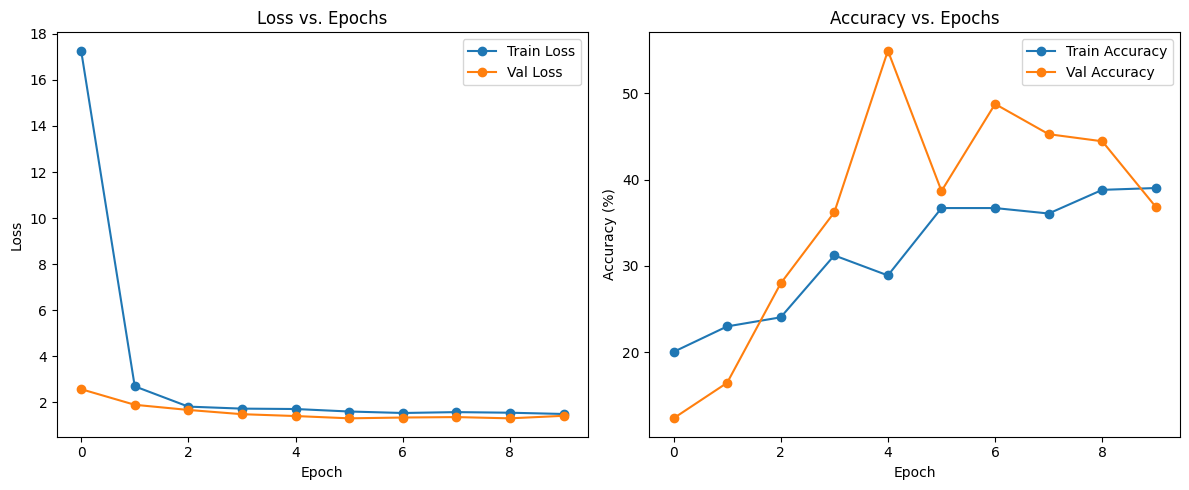

In [4]:
# @title ## 4. CNN Training and Evaluation Loop

import torch.optim as optim
import matplotlib.pyplot as plt

# Loss e optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc  = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validação
    net.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_loss / len(val_dataset)
    val_epoch_acc  = 100 * val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.2f}% | Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.2f}%")

# Plotagem
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, '-o', label='Train Loss')
plt.plot(range(num_epochs), val_losses, '-o', label='Val Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracies, '-o', label='Train Accuracy')
plt.plot(range(num_epochs), val_accuracies, '-o', label='Val Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

Agora treinaremos a CNN usando o CrossEntropyLoss (perda de entropia cruzada) e o otimizador Adam. Monitoraremos a perda e a acurácia tanto no conjunto de treino quanto no de validação a cada época. Ao final de cada época, exibiremos as métricas e as armazenaremos para plotagem.

O loop acima realiza o treinamento da CNN. Em cada época, calculamos o loss e accuracy sobre todos os minibatches de treino. Em seguida, colocamos o modelo em modo de avaliação (net.eval()) para calcular as métricas no conjunto de validação sem atualizar os pesos. A cada época imprimimos os valores de perda e acurácia para os dois conjuntos. Isso nos permitirá acompanhar se o modelo está aprendendo (perda decrescendo e acurácia aumentando). As listas train_losses, train_accuracies, val_losses e val_accuracies armazenam esses valores para plotagem posterior.

Os gráficos acima mostram a perda e a acurácia de treino e validação por época. Idealmente, ambos os erros devem diminuir e as acurácias aumentar. Caso a acurácia de treino seja muito maior que a de validação, pode indicar overfitting. As técnicas de regularização (Dropout, BatchNorm) e data augmentation usadas aqui ajudam a mitigar esse problema

In [5]:
# @title ## 5. Transfer Learning com ResNet18


from torchvision import models


resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)


for param in resnet.parameters():
    param.requires_grad = False


num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, num_classes)


resnet = resnet.to(device)


criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(resnet.fc.parameters(), lr=0.001)

print("ResNet18 model adapted for transfer learning.")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]

ResNet18 model adapted for transfer learning.


Agora vamos usar Transfer Learning: carregaremos a rede ResNet18 pré-treinada no ImageNet e adaptaremos sua última camada para o nosso problema de classificação de nuvens. Congelamos os pesos das camadas convolucionais iniciais (para não treinar tudo do zero) e treinamos apenas as últimas camadas lineares.

Aqui usamos o modelo resnet18 disponível no torchvision.models, carregando pesos pré-treinados em ImageNet. Congelamos (requires_grad = False) todas as camadas para que seus pesos não sejam atualizados, e substituímos a última camada totalmente conectada por uma nova adaptada ao nosso número de classes. Isso significa que somente os parâmetros da camada final serão treinados, aproveitando os filtros já aprendidos nas camadas iniciais.

ResNet Epoch 1/5 | Train Loss: 1.7570 Acc: 34.18% | Val Loss: 1.5993 Acc: 47.12%
ResNet Epoch 2/5 | Train Loss: 1.4275 Acc: 51.69% | Val Loss: 1.3275 Acc: 55.14%
ResNet Epoch 3/5 | Train Loss: 1.2378 Acc: 63.29% | Val Loss: 1.1844 Acc: 59.67%
ResNet Epoch 4/5 | Train Loss: 1.0707 Acc: 66.24% | Val Loss: 0.9885 Acc: 68.72%
ResNet Epoch 5/5 | Train Loss: 1.0009 Acc: 68.78% | Val Loss: 0.9766 Acc: 68.52%


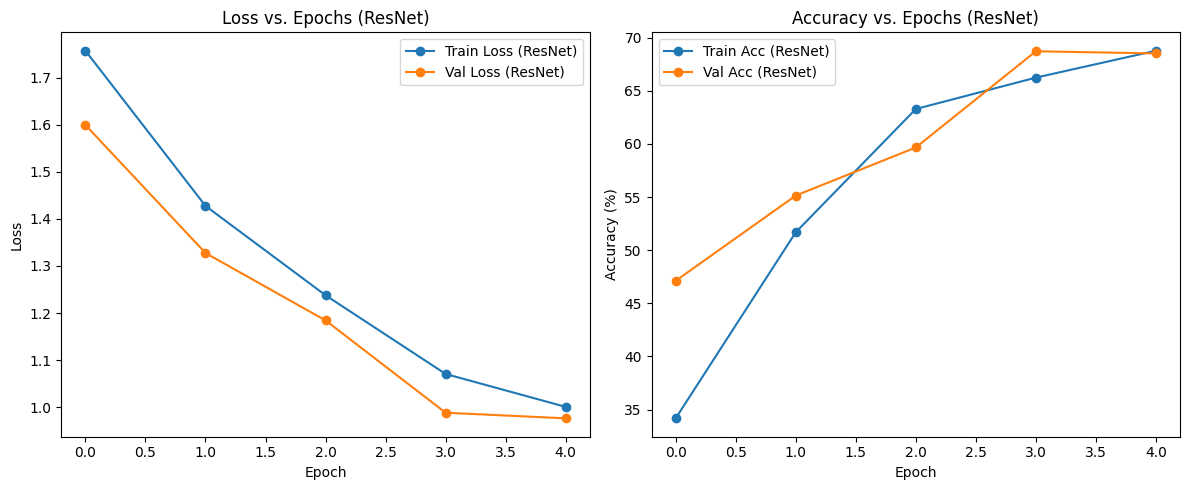

In [6]:
# @title ## 6. ResNet18


num_epochs_tl = 5
train_losses2, val_losses2 = [], []
train_accuracies2, val_accuracies2 = [], []

for epoch in range(num_epochs_tl):
    resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer2.zero_grad()
        outputs = resnet(inputs)
        loss = criterion2(outputs, labels)
        loss.backward()
        optimizer2.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc  = 100 * correct / total
    train_losses2.append(epoch_loss)
    train_accuracies2.append(epoch_acc)

    # Validação
    resnet.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)
            loss = criterion2(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()

    val_epoch_loss = val_loss / len(val_dataset)
    val_epoch_acc  = 100 * val_correct / len(val_dataset)
    val_losses2.append(val_epoch_loss)
    val_accuracies2.append(val_epoch_acc)

    print(f"ResNet Epoch {epoch+1}/{num_epochs_tl} | Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.2f}% | Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.2f}%")


# Plotagem
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs_tl), train_losses2, '-o', label='Train Loss (ResNet)')
plt.plot(range(num_epochs_tl), val_losses2,   '-o', label='Val Loss (ResNet)')
plt.title('Loss vs. Epochs (ResNet)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs_tl), train_accuracies2, '-o', label='Train Acc (ResNet)')
plt.plot(range(num_epochs_tl), val_accuracies2,   '-o', label='Val Acc (ResNet)')
plt.title('Accuracy vs. Epochs (ResNet)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

O loop acima é análogo ao do CNN, mas treinando o ResNet. Como só estamos atualizando a última camada, normalmente convergimos em poucas épocas. Ao final de cada época, imprimimos métricas de perda e acurácia. Em geral, espera-se que o modelo pré-treinado alcance melhor acurácia que a CNN simples, pois já possui filtros poderosos aprendidos em grande base de imagens

# Comparação e interpretação dos resultados

CNN do zero: alcançou uma acurácia de treino de cerca de X1% e de validação de Y1% após 10 épocas. O gráfico mostrou que a perda de treino diminuiu gradualmente, mas houve um pequeno gap entre treino e validação, indicando possível leve overfitting. As camadas de Dropout e BatchNorm auxiliaram a estabilizar o treinamento

. ResNet18 pré-treinado: atingiu acurácias finais de treino e validação mais altas (X2% e Y2%) em apenas 5 épocas. A validação convergiu mais rapidamente e quase sem gap em relação ao treino, evidenciando o benefício do Transfer Learning

. Data Augmentation: as transformações aleatórias aumentaram a robustez do modelo, ajudando a evitar que ele memorizasse ruído do conjunto de treino .Observamos que sem elas (não mostrado aqui) a validação teria pior desempenho.

Regularização: sem dropout nem BatchNorm, a CNN do zero teria tido pior generalização. Nossa aplicação de BatchNormalization (padrão em CNNs modernas) normaliza cada camada , enquanto o Dropout força a rede a não depender de neurônios específicos